In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$
$$
H_0 = \hbar  \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)}
+ \hbar \sum_{i,T_idx=1}^{N_\text{{atoms}}} J_{i T_idx} \sigma_+^{(i)} \sigma_-^{(T_idx)}
$$

$$
H_I = \hbar \Sigma_x E(t).
$$

$$
\displaystyle J_{i T_idx} = \frac{\alpha}{|r_i-r_j|}.
$$

In [ ]:
# Set the system parameters
n_rings = 1
n_chains = 1 # number of chains
N_atoms = n_chains * n_rings  # number of atoms

fixed_lam = 1.                # energysplitting of the atom, when ground state is set to 0
omega_a = 2 * np.pi / fixed_lam # actually k_a
omega_c = omega_a
distance = 1 * fixed_lam # defining topology                                    0.1 <--

gamma_0 = .1   # decay rate of the atoms
gamma_phi = .0 # dephasing rate of the atoms

alpha = 1. # coupling strength of the dipoles       Fine structure const?

# evolution
t_max = 10
time_steps = 10
t_step_width = t_max / time_steps
times = np.linspace(0, t_max, time_steps) # list of times
Ts = np.linspace(0, t_max, 3)

def count_decimal_digits(number):
    # Convert the number to string
    str_number = str(number)

    # Split the string at the decimal point and count the digits after it
    if '.' in str_number:
        return len(str_number.split('.')[1])
    else:
        return 0  # No digits after decimal if it's an integer

tolerance = count_decimal_digits(times[1]) - 2
tol = 10**-tolerance

In [ ]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])

def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos

In [ ]:
Pos = cyl_positions(distance, N_atoms, n_chains)

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
# Plot the positions
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [ ]:
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# combined dofs
sm_list = []    # lowering operators of atomic system
S_x = 0         # collective sigma_x operator for the system

for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()
    sm_list.append(op)
    S_x += op + op.dag()

In [ ]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))**3 * op
            else:
                H += omega_a * op # Diagonals except for |0><0|
    return H

H0 = Hamilton0(distance, n_rings, n_chains)

H0

In [ ]:
# Jump / Expect Operators
# Define the decay collapse and dephasing operator for each spin

op_list = sm_list  # Operators combining the cavity (qeye(2)) and the atomic lowering operator (sm)

# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in op_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in op_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators

# Expectation operators for measuring populations across atomic excited levels
e_op_list = [
    basis(N_atoms + 1, i) * basis(N_atoms + 1, i).dag()
    for i in range(N_atoms + 1)
]

e_op_list

In [ ]:
# create the time dependant evolution

I = S_x
E12 = 10 # Amplitude of laser pulses 1,2
E0s = [E12, E12, E12/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]
Delta_ts = [t_max/100, t_max/100, t_max/100] # narrow width of the pulses
phi12 = 2  * np.pi         # phis = [phi12, phi12, 0]  # Phase-kick?, pulse 1 and 2 are phase locked!

def heaviside(x):
    return 1 if x >= 0 else 0

def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    E = 1 / np.sqrt(2) * args['E0'] * heaviside(Delta - np.abs(t - t0)) * np.cos(np.pi*(t - t0)/(2*Delta))**2 * np.cos(args['omega'] * (t - t0) + args['phi'])
    return E

HI = [-I, El_field] # interaction Hamiltonian with function-based time dependence
H = [H0, HI]

options = Options(store_states=True)

In [ ]:
# evolution with t
# initial state
psiini = basis(N_atoms+1, 0) # = |g>_atom

#
# PREPROCESSING
#
# Define the phases, coherence times, and waiting times
phases = [i * np.pi/2 for i in range(4)]

# Initialize the main dictionary to hold the structure
data_dict_stage1 = {}
data_dict_stage2 = {}

# Loop through each phase φ
for phi in phases:
    data_dict_stage1[phi] = {}  # Stage 1 copy of the phase
    data_dict_stage2[phi] = {}  # Stage 2 copy of the phase

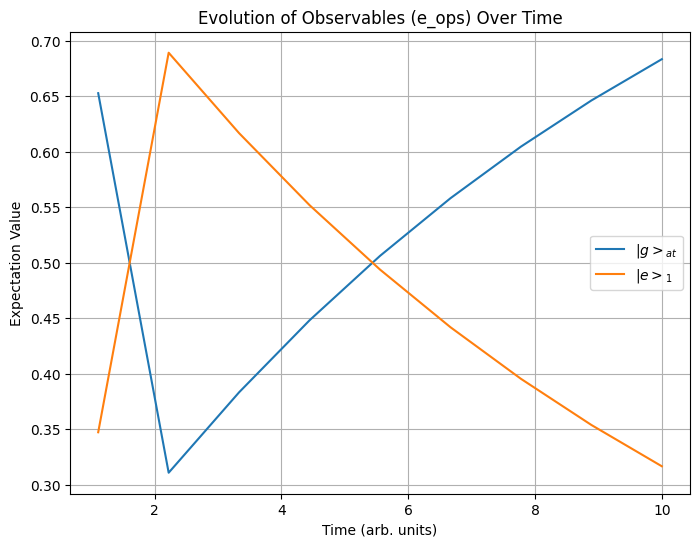

[[None,
  [None,
   [(np.float64(1.11111111111111),
     np.float64(1.11111111111111),
     np.float64(2.22222222222222),
     Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.52238705-6.37013718e-16j 0.03843573-4.14020281e-01j]
 [0.03843573+4.14020281e-01j 0.47761295+6.37013718e-16j]]),
    (np.float64(1.11111111111111),
     np.float64(1.11111111111111),
     np.float64(3.33333333333333),
     Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.52238705-6.37013718e-16j 0.03843573-4.14020281e-01j]
 [0.03843573+4.14020281e-01j 0.47761295+6.37013718e-16j]]),
    (np.float64(1.11111111111111),
     np.float64(1.11111111111111),
     np.float64(4.44444444444444),
     Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.52238705-6.37013718e-16j 0.03843573-4.14020281e-01j]
 [0.03843573+4.14020281e-01j 0.47761295+6.37013718e-16j]]),
    (np.flo

In [90]:
#
# CALCULATIONS
#

data_array = [[] for _ in range(len(phases))]  # Start with an empty list for each phi_idx

# (first laser pulse)
times_0 = times

# Iterate over the phi values
for phi_idx, phi in enumerate(phases):
    args_0 = {
        'phi': phi12,  # Use the phase 0
        'time': Delta_ts[0],  # t0 value = Delta value such that the pulse immediatley starts
        'omega': omegas[0],  # omega value
        'Delta': Delta_ts[0], # The width should be
        'E0': E0s[0]  # E0 value
    }
    data_array[phi_idx] = [None] * len(times_0)  # Assign an empty list (or None) for each tau_idx
    # Solve the system using mesolve (first laser pulse)
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, e_ops=e_op_list, args=args_0, options=options)

    for tau_idx in range(len(times_0)): # save only the states that make sense
        if (2 * Delta_ts[0] <= times_0[tau_idx] <= t_max - 2 * (Delta_ts[1] + Delta_ts[2])):
            psiini_1 = result_0.states[tau_idx]

            times_1 = times[tau_idx:]

            # Define the parameters for the second laser pulse
            args_1 = {
                'phi': phi12,
                'time': times_1[0] + Delta_ts[1],
                'omega': omegas[1],
                'Delta': Delta_ts[1],
                'E0': E0s[1]
            }

            if data_array[phi_idx][tau_idx] is None:
                data_array[phi_idx][tau_idx] = [None] * len(times_1)

            # Solve the system for the second laser pulse
            result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, e_ops=e_op_list, args=args_1, options=options)

            # Iterate over the time indices to filter and store results
            for T_idx in range(len(times_1)): # save only the states that make sense
                if (times[tau_idx] + 2 * Delta_ts[1] <= times_1[T_idx] <= t_max - 2 * Delta_ts[2]):
                    psiini_2 = result_1.states[T_idx]

                    times_2 = times_1[T_idx:]

                    if data_array[phi_idx][tau_idx][T_idx] is None:
                        data_array[phi_idx][tau_idx][T_idx] = [None] * len(times_2)

                    # Define the parameters for the third laser pulse
                    args_2 = {
                        'phi': 0,  # Last pulse has no phase kick
                        'time': times_2[0] + Delta_ts[2],
                        'omega': omegas[2],
                        'Delta': Delta_ts[2],
                        'E0': E0s[2],
                    }

                    # Solve the system for the third laser pulse
                    result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, args=args_2, options=options)

                    # Save all valid states and corresponding times within the valid time range
                    for t_idx in range(len(times_2)):
                        if (times[tau_idx] + 2 * Delta_ts[2] <= times_2[t_idx] <= t_max):
                            psi_T_tau_t = result_2.states[t_idx]
                            # Compute and round the coherence time τ, waiting time T, time t
                            coherence_time_i = times[tau_idx] + Delta_ts[1] - Delta_ts[0]
                            tau = round(coherence_time_i, tolerance)
                            waiting_time_j = times_1[T_idx] - times[tau_idx] + Delta_ts[2] - Delta_ts[1]
                            T = round(waiting_time_j, tolerance)
                            # Round the current time point t
                            t = round(times_2[t_idx], tolerance)

                            data_array[phi_idx][tau_idx][T_idx][t_idx] = (T, tau, t, psi)

                        #
                        # PLOT TO CHECK the evolution
                        #
                    # Plot each observable in `e_ops`
                    if phi_idx == 0 and tau_idx == 1 and T_idx == 1:
                        data_array[phi_idx][tau_idx][T_idx][t_idx]
                        plt.figure(figsize=(8, 6))
                        for i, e_op_expect in enumerate(result_1.expect):
                            if i ==0:
                                label=r"$|g>_{at}$"
                            else:
                                label=f"$|e>_{i}$"
                            plt.plot(result_1.times, e_op_expect, label=label)

                        # Add labels and legend
                        plt.xlabel("Time (arb. units)")
                        plt.ylabel("Expectation Value")
                        plt.title("Evolution of Observables (e_ops) Over Time")
                        plt.legend()
                        plt.grid()
                        plt.show()

pprint.pprint(data_array)

In [93]:
# Post-processing: Compute averages over phi and organize results into 2D arrays for each T_idx

# Final post-processed data dictionary
data_array_stage4 = {}  # Holds expectation values for each T_idx

# Iterate through the structure carefully, taking into account possible None values
for phi_idx in range(len(data_array)):  # Iterate over phi indices
    if data_array[phi_idx] is None:
        continue  # Skip if the phi level is not populated

    for tau_idx in range(len(data_array[phi_idx])):  # Iterate over tau_idx
        if data_array[phi_idx][tau_idx] is None:
            continue  # Skip if the tau level is not populated

        for T_idx in range(len(data_array[phi_idx][tau_idx])):  # Iterate over T_idx
            if data_array[phi_idx][tau_idx][T_idx] is None:
                continue  # Skip if the T level is not populated

            for t_idx in range(len(data_array[phi_idx][tau_idx][T_idx])):  # Iterate over t_idx
                if data_array[phi_idx][tau_idx][T_idx][t_idx] is None:
                    continue  # Skip if the t level is not populated

                # Extract T, tau, t, and psi for processing
                try:
                    T, tau, t, psi = data_array[phi_idx][tau_idx][T_idx][t_idx]
                except ValueError:
                    # Handle unexpected data structure issues gracefully
                    continue

                # Compute or initialize mean_psi if this point relevant
                if T_idx not in data_array_stage4:
                    data_array_stage4[T_idx] = {}
                if tau_idx not in data_array_stage4[T_idx]:
                    data_array_stage4[T_idx][tau_idx] = {}
                if t_idx not in data_array_stage4[T_idx][tau_idx]:
                    data_array_stage4[T_idx][tau_idx][t_idx] = {'mean_psi': 0, 'phi_count': 0}

                # Accumulate psi for averaging, if it exists
                if psi is not None:
                    data_array_stage4[T_idx][tau_idx][t_idx]['mean_psi'] += psi
                    data_array_stage4[T_idx][tau_idx][t_idx]['phi_count'] += 1

# Finalize averages for all collected data
for T_idx, tau_idx_dict in data_array_stage4.items():
    for tau_idx, t_idx_dict in tau_idx_dict.items():
        for t_idx, values in t_idx_dict.items():
            phi_count = values['phi_count']
            if phi_count > 0:
                averaged_psi = values['mean_psi'] / phi_count
                # Optionally compute expectation value with S_x
                data_array_stage4[T_idx][tau_idx][t_idx] = expect(S_x, averaged_psi)
            else:
                # If no valid psi was found, set as None
                data_array_stage4[T_idx][tau_idx][t_idx] = None

# Print or summarize the processed data structure
pprint.pprint(data_array_stage4)


{1: {1: {0: 0.07687146597122368,
         1: 0.07687146597122368,
         2: 0.07687146597122368,
         3: 0.07687146597122368,
         4: 0.07687146597122368,
         5: 0.07687146597122368,
         6: 0.07687146597122368,
         7: 0.07687146597122368},
     2: {0: 0.07687146597122368,
         1: 0.07687146597122368,
         2: 0.07687146597122368,
         3: 0.07687146597122368,
         4: 0.07687146597122368,
         5: 0.07687146597122368,
         6: 0.07687146597122368},
     3: {0: 0.07687146597122368,
         1: 0.07687146597122368,
         2: 0.07687146597122368,
         3: 0.07687146597122368,
         4: 0.07687146597122368,
         5: 0.07687146597122368},
     4: {0: 0.07687146597122368,
         1: 0.07687146597122368,
         2: 0.07687146597122368,
         3: 0.07687146597122368,
         4: 0.07687146597122368},
     5: {0: 0.07687146597122368,
         1: 0.07687146597122368,
         2: 0.07687146597122368,
         3: 0.07687146597122368},
     

In [ ]:
# Create a dictionary to store 2D arrays for each T_idx
arrays_for_T = {}

for T_idx in range(data_array_stage4.shape[0]):  # Iterate over T values (T_idx)
    valid_combinations = []  # To store valid [t_idx, tau_idx] pairs for this T_idx

    for tau_idx in range(data_array_stage4.shape[1]):  # Iterate over tau values (tau_idx)
        for t_idx in range(data_array_stage4.shape[2]):  # Iterate over time values (t_idx)
            expect_val = data_array_stage4[T_idx, tau_idx, t_idx]

            # Only keep combinations where the expectation value is not None
            if expect_val is not None:
                valid_combinations.append([t_idx, tau_idx])

    # Convert valid combinations to a NumPy array
    valid_combinations_array = np.array(valid_combinations)

    # Check if both dimensions have at least 2 unique values
    if valid_combinations_array.shape[0] > 0:  # Ensure it's not empty first
        unique_t_idx = np.unique(valid_combinations_array[:, 0])
        unique_tau_idx = np.unique(valid_combinations_array[:, 1])
        if len(unique_t_idx) >= 2 and len(unique_tau_idx) >= 2:
            arrays_for_T[T_idx] = valid_combinations_array

# Output: Dictionary `arrays_for_T` where each T_idx corresponds to a 2D array
for T_idx, array in arrays_for_T.items():
    print(f"T_idx = {T_idx}:")
    print(array)

In [ ]:
# Combine all unique ts and taus across all entries
data_array_stage4 = 0
global_ts = 0
for T_idx in range(data_array_stage3.shape[1]):  # Iterate over T values (T)
    for tau_idx in range(data_array_stage3.shape[2]):  # Iterate over tau values (τ)
        for t_idx in range(data_array_stage3.shape[3]):
            if data_array_stage3[T_idx, tau_idx, t_idx] != None

global_taus = ...
print(global_taus, global_ts)

# Create the global meshgrid
X_global, Y_global = np.meshgrid(global_ts, global_taus)


In [ ]:

# Fill the global 2D array with available data
for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Only plot every 10th entry
    if idx % 10 != 0:
        continue

    # Initialize a global data array with zeros
    data = np.full(X_global.shape, 0.0)

    # Map local indices (ts to global_ts and taus to global_taus) using np.isclose
    ts_indices = [i for t in ts for i, global_t in enumerate(global_ts) if np.isclose(global_t, t)]
    taus_indices = [i for tau in taus for i, global_tau in enumerate(global_taus) if np.isclose(global_tau, tau)]

    # Validate that mapping worked correctly
    if len(ts_indices) != len(ts) or len(taus_indices) != len(taus):
        print(f"Warning: Not all ts or taus mapped correctly for T={T}.")

    # Fill the global 2D array with the local data
    for local_tau_idx, global_tau_idx in enumerate(taus_indices):
        for local_t_idx, global_t_idx in enumerate(ts_indices):
            if 0 <= global_tau_idx < data.shape[0] and 0 <= global_t_idx < data.shape[1]:
                data[global_tau_idx, global_t_idx] = twoD_times[local_t_idx, local_tau_idx]
            else:
                print(f"Skipping out-of-bounds index: ({global_tau_idx}, {global_t_idx}) for T={T}.")

    # Plot the real-space data using imshow
    plt.figure(figsize=(10, 8))
    extent = [global_ts[0], global_ts[-1], global_taus[0], global_taus[-1]]  # Set extent for proper axis scaling
    plt.imshow(data, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label="Intensity")
    plt.title(f"2D Real Space for T={T:.2f}")
    plt.xlabel("Detection Time (ts)")
    plt.ylabel("Excitation Time (taus)")
    plt.show()

In [ ]:
# Step 3: Process each entry by performing Fourier Transform
for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Only process every 10th entry
    if idx % 1 != 0:
        continue

    # Compute 2D Fourier Transform on the `twoD_times` data
    FT_data = np.fft.fft2(twoD_times)

    # Local ts and taus frequency axes
    t_freqs = np.fft.fftfreq(len(ts), d=(ts[1] - ts[0]))
    tau_freqs = np.fft.fftfreq(len(taus), d=(taus[1] - taus[0]))
    t_freqs_2D = t_freqs[:, np.newaxis]  # Reshape t_freqs into a column vector for broadcasting

    # Compute the intensity (A), using the imaginary part of FT data
    A = -t_freqs_2D * np.imag(FT_data)
    # Normalize A by its maximum absolute value for better visualization
    max_abs_A = np.max(np.abs(A))
    if max_abs_A != 0:  # Avoid division by zero
        A = A / max_abs_A

    # Step 3: Visualize the 2D spectroscopy data as a contour plot
#    plt.figure(figsize=(8, 6))
#    contour = plt.contourf(global_t_freqs, global_tau_freqs, A, cmap='viridis')  # Transpose A for proper orientation
#    plt.colorbar(contour, label="Intensity")
#    plt.title(f"2D Spectroscopy for T={T:.2f}")
#    plt.xlabel("$\\omega_{det}$ (arb. units)")
#    plt.ylabel("$\\omega_{exc}$ (arb. units)")
#    plt.show()

    plt.figure(figsize=(8, 6))
    extent = [t_freqs.min(), t_freqs.max(), tau_freqs.min(), tau_freqs.max()]
    plt.imshow(A, extent=extent, origin='lower', aspect='auto', cmap='viridis')  # Display A as an image
    plt.colorbar(label="Intensity")
    plt.title(f"2D Spectroscopy for T={T:.2f}")
    plt.xlabel("$\omega_{det}$ (arb. units)")
    plt.ylabel("$\omega_{exc}$ (arb. units)")
    plt.show()

In [ ]:
# Step 1: Create global frequency axis for all entries
all_t_freqs = []
all_tau_freqs = []

for _, (_, ts, taus) in two_d_array_dict.items():
    if len(ts) > 2 and len(taus) > 2:  # Ensure valid data
        t_freqs = np.fft.fftfreq(len(ts), ts[1] - ts[0])  # Detection frequencies
        tau_freqs = np.fft.fftfreq(len(taus), taus[1] - taus[0])  # Excitation frequencies
        all_t_freqs.extend(t_freqs)
        all_tau_freqs.extend(tau_freqs)

# Take only unique frequencies to generate global frequency axes
global_t_freqs = np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0]))
global_tau_freqs = np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0]))

# Create global meshed frequency grid for plotting
X_global_freqs, Y_global_freqs = np.meshgrid(global_t_freqs, global_tau_freqs)

# Step 2: Process each entry by performing Fourier Transform
for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    if idx % 10 != 0:
        continue

    # Compute 2D Fourier Transform (complex coefficients)
    FT_data = np.fft.fft2(twoD_times)

    # Compute local frequency axes
    t_freqs = np.fft.fftfreq(len(ts), ts[1] - ts[0])
    tau_freqs = np.fft.fftfreq(len(taus), taus[1] - taus[0])

    # Initialize a global frequency-space array
    data = np.zeros(X_global_freqs.shape, dtype=complex)

    # Map local ts and taus to global Fourier frequencies using np.isclose
    ts_indices = [i for t in ts for i, f_t in enumerate(global_t_freqs) if
                  np.isclose(f_t, np.fft.fftfreq(len(ts), d=(ts[1] - ts[0]))[ts.index(t)])]
    taus_indices = [i for tau in taus for i, f_tau in enumerate(global_tau_freqs) if
                    np.isclose(f_tau, np.fft.fftfreq(len(taus), d=(taus[1] - taus[0]))[taus.index(tau)])]

    # Validate mapping
    if len(ts_indices) != len(ts) or len(taus_indices) != len(taus):
        print(
            f"Warning: Some ts or taus could not be mapped correctly for T={T}. Check frequency resolution or input data.")

    # Fill the global 2D Fourier space array with the local data
    for local_tau_idx, global_tau_idx in enumerate(taus_indices):
        for local_t_idx, global_t_idx in enumerate(ts_indices):
            if 0 <= global_tau_idx < data.shape[0] and 0 <= global_t_idx < data.shape[1]:
                # Assign the Fourier-transformed data
                data[global_tau_idx, global_t_idx] = twoD_times[local_tau_idx, local_t_idx]
            else:
                print(f"Skipping out-of-bounds index: ({global_tau_idx}, {global_t_idx}) for T={T}.")


    # Step 3: Normalize the FT data for intensity visualization (optional)
    intensity = np.abs(data)  # Magnitude of complex data
    max_intensity = np.max(intensity)
    if max_intensity != 0:  # Normalize
        intensity /= max_intensity

    # Step 4: Visualize the Fourier Transformed Data
    plt.figure(figsize=(10, 8))
    extent = [global_t_freqs[0], global_t_freqs[-1], global_tau_freqs[0], global_tau_freqs[-1]]
    plt.imshow(intensity, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label="Normalized Intensity")
    plt.title(f"2D Fourier Transform for T={T:.2f}")
    plt.xlabel("$\omega_{det}$ (Detection Frequency, arb. units)")
    plt.ylabel("$\omega_{exc}$ (Excitation Frequency, arb. units)")
    plt.show()

In [ ]:
# Step 1: Create a global grid for t_freqs and tau_freqs
all_t_freqs = []
all_tau_freqs = []
FT_data_dict = {}
for T, (twoD_times, ts, taus) in two_d_array_dict.items():
    if len(ts) > 2 and len(taus) > 2:  # Ensure valid data
        t_freqs = np.fft.fftfreq(len(ts), ts[1] - ts[0])
        tau_freqs = np.fft.fftfreq(len(taus), taus[1] - taus[0])
        # Collect all frequencies (including negative) for later processing
        all_t_freqs.extend(t_freqs)
        all_tau_freqs.extend(tau_freqs)

# Take only unique frequencies to generate global frequency axes
global_t_freqs = sorted(np.unique(all_t_freqs))
global_tau_freqs = sorted(np.unique(all_tau_freqs))

# Create a global grid (meshed grid for 2D plotting)
global_t_freqs, global_tau_freqs = np.meshgrid(global_t_freqs, global_tau_freqs)

#print(global_t_freqs, global_tau_freqs)

# Step 2: Process each 2D dataset
for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Only process every entry, currently set to process all
    if idx % 1 != 0:
        continue

    # Compute the 2D Fast Fourier Transform
    FT_data = np.fft.fft2(twoD_times)  # Complex Fourier coefficients

    # Compute the local frequency axes for ts and taus
    t_freqs = np.fft.fftfreq(len(ts), ts[1] - ts[0])
    tau_freqs = np.fft.fftfreq(len(taus), taus[1] - taus[0])

    # Map local frequencies to global grid indices
    ts_indices = [np.where(global_t_freqs[0] == t)[0][0] for t in t_freqs]  # `global_t_freqs[0]` since it's 2D
    taus_indices = [np.where(global_tau_freqs[:, 0] == tau)[0][0] for tau in
                tau_freqs]

    # Initialize a global grid for storing FT data
    FT_data_full = np.full(global_t_freqs.shape, np.nan + 0j, dtype=complex)  # or np.complex128

    # Populate global grid with FT data safely
    for i, tau_idx in enumerate(taus_indices):
        if tau_idx >= FT_data_full.shape[0]:
            continue  # Skip out-of-bounds indices for tau
        for T_idx, t_idx in enumerate(ts_indices):
            if t_idx >= FT_data_full.shape[1]:
                continue  # Skip out-of-bounds indices for t
            FT_data_full[tau_idx, t_idx] = FT_data[T_idx, i]

    # Reshape t_freqs for broadcasting, to allow element-wise multiplication
    # Broadcasting is required to match the dimensions of `t_freqs_2D` (1D array reshaped to column)
    # to the dimensions of `FT_data_full` (2D array). This allows operations between the t_freqs
    # and the corresponding values in the Fourier data for visualization.
    t_freqs_2D = global_t_freqs[:]

    # Compute the intensity (A), using the imaginary part of FT data
    A = -t_freqs_2D * np.imag(FT_data_full)
    # Normalize A by its maximum absolute value for better visualization
    max_abs_A = np.max(np.abs(A))
    if max_abs_A != 0:  # Avoid division by zero
        A = A / max_abs_A

    # Step 3: Visualize the 2D spectroscopy data as a contour plot
#    plt.figure(figsize=(8, 6))
#    contour = plt.contourf(global_t_freqs, global_tau_freqs, A, cmap='viridis')  # Transpose A for proper orientation
#    plt.colorbar(contour, label="Intensity")
#    plt.title(f"2D Spectroscopy for T={T:.2f}")
#    plt.xlabel("$\\omega_{det}$ (arb. units)")
#    plt.ylabel("$\\omega_{exc}$ (arb. units)")
#    plt.show()

    plt.figure(figsize=(8, 6))
    extent = [global_t_freqs.min(), global_t_freqs.max(), global_tau_freqs.min(), global_tau_freqs.max()]
    plt.imshow(A, extent=extent, origin='lower', aspect='auto', cmap='viridis')  # Display A as an image
    plt.colorbar(label="Intensity")
    plt.title(f"2D Spectroscopy for T={T:.2f}")
    plt.xlabel("$\omega_{det}$ (arb. units)")
    plt.ylabel("$\omega_{exc}$ (arb. units)")
    plt.show()

In [ ]:
# Perform computation of A = -t_freqs * IM(FT_data) for each T
for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Only plot every 10th entry
    if idx % 10 != 0:
        continue

    # Compute the 2D Fast Fourier Transform
    FT_data = np.fft.fft2(twoD_times)  # Complex Fourier coefficients
    # Shift zero frequency component to the center
    FT_data_shifted = np.fft.fftshift(FT_data)

    # Compute frequency arrays for the t-axis
    if len(ts) > 2:
        t_freqs = np.fft.fftshift(np.fft.fftfreq(len(ts), ts[1] - ts[0]))
    else:
        continue

    # Compute frequency arrays for the tau-axis
    if len(taus) > 2:
        tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(taus), taus[1] - taus[0]))
    else:
        continue

    # Ensure no mismatch between tau_freqs and FT_data dimensions
    assert len(tau_freqs) == FT_data_shifted.shape[1], "Mismatch between tau_freqs and FT_data dimensions!"

    # Identify positive frequencies in tau_freqs
    positive_indices_tau = np.where(tau_freqs >= 0)[0]
    negative_indices_tau = len(tau_freqs) - positive_indices_tau - 1
    positive_part_tau = FT_data_shifted[:, positive_indices_tau]
    negative_part_tau = FT_data_shifted[:, negative_indices_tau]  # Mirrored negative parts (correct symmetry)

    # Combine data: average the contributions of positive and negative parts
    combined_data_tau = (positive_part_tau + negative_part_tau) / 2

    # Update tau_freqs to only positive frequencies
    tau_freqs_positive = tau_freqs[positive_indices_tau]

    # Identify positive frequencies in t_freqs
    positive_indices_t = np.where(t_freqs >= 0)[0]
    negative_indices_t = len(t_freqs) - positive_indices_t - 1
    positive_part_t = combined_data_tau[positive_indices_t, :]
    negative_part_t = combined_data_tau[negative_indices_t, :]

    # Combine data: average the contributions of positive and negative parts for t_freqs
    combined_data = (positive_part_t + negative_part_t) / 2

    # Update t_freqs to only positive frequencies
    t_freqs_positive = t_freqs[positive_indices_t]

    # Now operate on combined data
    # Fix broadcasting issue by reshaping the positive frequencies
    t_freqs_2D_positive = t_freqs_positive[:, np.newaxis]  # Reshape for broadcasting
    safe_t_freqs_2D_pos = np.where(t_freqs_2D_positive == 0, 1, t_freqs_2D_positive)  # Avoid division by zero

    # Compute A
    A = -t_freqs_2D_positive * np.imag(combined_data)

    # Normalize A by its maximum absolute value
    max_abs_A = np.max(np.abs(A))
    if max_abs_A != 0:  # Avoid division by zero
        A = A / max_abs_A

    # Plot A with updated tau_freqs_positive
    plt.figure(figsize=(8, 6))
    plt.contourf(
        t_freqs_positive,  # x-axis: ω_det
        tau_freqs_positive,  # y-axis: ω_exc (positive frequencies only)
        A.T,
        cmap="coolwarm"
    )

    plt.colorbar()
    plt.title(f"2D spectroscopy for T={T:.2f}")
    plt.xlabel("$\\omega_{det}$ arb. units")
    plt.ylabel("$\\omega_{exc} (> 0)$ arb. units")  # Highlight positive frequencies
    plt.show()

In [ ]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

# Initialize empty lists to store frequency axes and spectra
all_t_freqs_pos = []
all_tau_freqs_pos = []
all_spectra = []  # To store the processed spectra for each T

for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Perform Fourier Transform and extract positive frequencies
    FT_data = np.fft.fft2(twoD_times)  # Complex Fourier coefficients
    FT_data_shifted = np.fft.fftshift(FT_data)

    # Compute t and tau frequency arrays
    if len(ts) > 2:
        t_freqs = np.fft.fftshift(np.fft.fftfreq(len(ts), ts[1] - ts[0]))
    else:
        continue

    if len(taus) > 2:
        tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(taus), taus[1] - taus[0]))
    else:
        continue

    # Ensure no mismatch in dimensions
    assert len(tau_freqs) == FT_data_shifted.shape[1], "Mismatch between tau_freqs and FT_data dimensions!"

    # Extract positive t and tau frequencies
    positive_indices_tau = np.where(tau_freqs >= 0)[0]
    positive_indices_t = np.where(t_freqs >= 0)[0]

    positive_part_tau = FT_data_shifted[:, positive_indices_tau]
    tau_freqs_positive = tau_freqs[positive_indices_tau]

    positive_part_t = positive_part_tau[positive_indices_t, :]
    t_freqs_positive = t_freqs[positive_indices_t]

    # Normalize the combined data
    t_freqs_2D_positive = t_freqs_positive[:, np.newaxis]  # Reshape for operation
    A = -t_freqs_2D_positive * np.imag(positive_part_t)

    # Normalize the spectrum for this T
    max_abs_A = np.max(np.abs(A))
    if max_abs_A != 0:  # Avoid division by zero
        A = A / max_abs_A

    # Append frequencies and the spectrum
    all_t_freqs_pos.append(t_freqs_positive)
    all_tau_freqs_pos.append(tau_freqs_positive)
    all_spectra.append(A)

# Step 1: Create global grid by merging all frequency axes
global_t_freqs = np.unique(np.concatenate(all_t_freqs_pos))  # Unique sorted frequencies
global_tau_freqs = np.unique(np.concatenate(all_tau_freqs_pos))  # Unique sorted frequencies
global_t_grid, global_tau_grid = np.meshgrid(global_t_freqs, global_tau_freqs)

# Debug: Print shapes of the global grid
print(f"Global t grid shape: {global_t_grid.shape}")
print(f"Global tau grid shape: {global_tau_grid.shape}")

# Step 2: Initialize a matrix to store the integrated result
integrated_result = np.zeros_like(global_t_grid, dtype=np.float64)

# Step 3: Interpolate spectra onto the global grid
for t_freqs_positive, tau_freqs_positive, A in zip(all_t_freqs_pos, all_tau_freqs_pos, all_spectra):
    # Flatten the t and tau frequency arrays to use with griddata
    points = np.array(np.meshgrid(t_freqs_positive, tau_freqs_positive)).reshape(2, -1).T
    A_interpolated = griddata(
        points, A.ravel(), (global_t_grid, global_tau_grid), method="linear", fill_value=0
    )

    # Accumulate the interpolated result
    integrated_result += A_interpolated

# Normalize the integrated result after accumulation
max_abs_integrated = np.max(np.abs(integrated_result))
if max_abs_integrated != 0:  # Avoid division by zero
    integrated_result /= max_abs_integrated

# Debug: Print the shape of the integrated result
print(f"Integrated result shape: {integrated_result.shape}")

plt.figure(figsize=(8, 6))
plt.imshow(
    integrated_result.T,  # Transpose to align axes correctly
    aspect='auto',  # Adjust the aspect ratio to match the data
    extent=(global_t_freqs[0], global_t_freqs[-1], global_tau_freqs[0], global_tau_freqs[-1]),
    origin='lower',  # Place the smallest values at the bottom left corner
    cmap="coolwarm"
)
plt.colorbar(label="Integrated Amplitude")
plt.title("Integrated Spectrum Over T")
plt.xlabel("Detection Frequency (ω_det)")
plt.ylabel("Excitation Frequency (ω_exc)")
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
plt.pcolormesh(global_t_freqs, global_tau_freqs, integrated_result, cmap="coolwarm", shading="auto")
plt.colorbar(label="Integrated Amplitude")
plt.title("Integrated Spectrum Over T")
plt.xlabel("Detection Frequency (ω_det)")
plt.ylabel("Excitation Frequency (ω_exc)")
plt.show()

In [ ]:
import numpy as np
from scipy.fft import fft, fftshift

# Generate a simple signal
x = np.linspace(0, 2*np.pi, 128)
y = np.sin(x)

# Compute the FFT
Y = fft(y)

# Shift the FFT
Y_shifted = fftshift(Y)

# Compare
print(Y[0:5]) # Original FFT output
print(Y_shifted[0:5]) # After fftshift

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift

# Generate a complex signal
sample_rate = 1000
T = 1/sample_rate
t = np.linspace(0, 1.0, int(1/T), endpoint=False)
y = np.sin(50 * 2 * np.pi * t) + 0.5 * np.sin(80 * 2 * np.pi * t)

# Compute and shift FFT
Y = fft(y)
Y_shifted = fftshift(Y)
xf = np.linspace(-sample_rate/2, sample_rate/2, len(y))

# Plot
plt.figure()
plt.plot(xf, np.imag(Y))
plt.title('Shifted Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (x_vals and y_vals)
x_vals = np.linspace(0, 10, 1000)  # Example time or space domain
y_vals = np.exp(-0.5 * ((x_vals - 5) / 1)**2)  # Gaussian centered at 5 with std dev = 1
y_vals = np.sign(np.sin(2 * np.pi * 1 * x_vals))  # Square wave with 1 Hz frequency

# Step 1: Compute the Fourier Transform using numpy's fft.fft
ft_vals = np.fft.fft(y_vals)

# Step 2: Compute the corresponding frequency values
delta_x = x_vals[1] - x_vals[0]  # spacing between data points
sampling_rate = 1 / delta_x

# Frequencies associated with the Fourier Transform
n = len(x_vals)  # number of points
freq_vals = np.fft.fftfreq(n, delta_x)  # Frequencies for the DFT

# Step 3: Only keep the positive frequencies (and the corresponding FFT values)
# Positive frequencies are from index 0 to n//2 (inclusive) in the FFT output
positive_freqs = freq_vals[:n//2]
positive_ft_vals = ft_vals[:n//2]

# Step 4: Plot the results (Magnitude of the FT for positive frequencies)
plt.figure(figsize=(10, 5))

# Plot the magnitude of the FT for positive frequencies
plt.subplot(1, 2, 1)
plt.plot(positive_freqs, np.abs(positive_ft_vals))
plt.title('Magnitude of Fourier Transform (Positive Frequencies)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

# Plot the original data
plt.subplot(1, 2, 2)
plt.plot(x_vals, y_vals)
plt.title('Original Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D grid
x_vals = np.linspace(-10, 10, 256)  # X axis
y_vals = np.linspace(-10, 10, 256)  # Y axis
X_vals, Y_vals = np.meshgrid(x_vals, y_vals)  # Create a 2D grid of coordinates

# Choose any 2D function for Y_vals
Y_vals = np.sin(2 * np.pi * 1 * X_vals) * np.sin(2 * np.pi * 1 * Y_vals)  # Example: 2D sine wave
#Y_vals = np.sign(np.sin(2 * np.pi * X_vals)) * np.sign(np.sin(2 * np.pi * Y_vals))

# Step 1: Compute the 2D Fourier Transform using numpy's fft2
FT_vals = np.fft.fft2(Y_vals)

# Step 2: Shift the zero frequency component to the center
FT_vals_shifted = np.fft.fftshift(FT_vals)

# Step 3: Compute the corresponding frequency values for both axes
delta_x = x_vals[1] - x_vals[0]
delta_y = y_vals[1] - y_vals[0]
freq_x = np.fft.fftfreq(len(x_vals), delta_x)  # Frequencies for the X axis
freq_y = np.fft.fftfreq(len(y_vals), delta_y)  # Frequencies for the Y axis
freq_x, freq_y = np.meshgrid(freq_x, freq_y)  # Create a 2D meshgrid for the frequencies

# Step 5: Plot the results (Magnitude of the FT for positive frequencies)
magnitude = np.abs(FT_vals_shifted)

# Plot the magnitude of the Fourier Transform (log scale for better visualization)
plt.figure(figsize=(8, 6))
plt.imshow(np.log(1 + magnitude), extent=(freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()))
plt.title('Magnitude of 2D Fourier Transform (Positive Frequencies)')
plt.xlabel('Frequency in X (Hz)')
plt.ylabel('Frequency in Y (Hz)')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()
